UNET code from: https://raw.githubusercontent.com/Lasagne/Recipes/master/modelzoo/Unet.py

In [1]:
import theano, theano.tensor as T
import numpy as np, matplotlib.pyplot as plt
import os, time, random, sys

import collections
import lasagne

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 0.8.2.dev-RELEASE
lasagne 0.2.dev1


In [2]:
from lasagne.layers import (InputLayer, ConcatLayer, Pool2DLayer, ReshapeLayer, DimshuffleLayer, NonlinearityLayer,
                            DropoutLayer, Deconv2DLayer, batch_norm)
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except ImportError:
    from lasagne.layers import Conv2DLayer as ConvLayer
import lasagne
from lasagne.init import HeNormal

def build_UNet(n_input_channels=1, BATCH_SIZE=None, num_output_classes=2, pad='same', nonlinearity=lasagne.nonlinearities.elu, input_dim=(128, 128), base_n_filters=64, do_dropout=False):
    net = collections.OrderedDict()
    net['input'] = InputLayer((BATCH_SIZE, n_input_channels, input_dim[0], input_dim[1]))

    net['contr_1_1'] = batch_norm(ConvLayer(net['input'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_1_2'] = batch_norm(ConvLayer(net['contr_1_1'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool1'] = Pool2DLayer(net['contr_1_2'], 2)

    net['contr_2_1'] = batch_norm(ConvLayer(net['pool1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_2_2'] = batch_norm(ConvLayer(net['contr_2_1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool2'] = Pool2DLayer(net['contr_2_2'], 2)

    net['contr_3_1'] = batch_norm(ConvLayer(net['pool2'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_3_2'] = batch_norm(ConvLayer(net['contr_3_1'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool3'] = Pool2DLayer(net['contr_3_2'], 2)

    net['contr_4_1'] = batch_norm(ConvLayer(net['pool3'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_4_2'] = batch_norm(ConvLayer(net['contr_4_1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    l = net['pool4'] = Pool2DLayer(net['contr_4_2'], 2)


    net['encode_1'] = batch_norm(ConvLayer(l, base_n_filters*16, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['encode_2'] = batch_norm(ConvLayer(net['encode_1'], base_n_filters*16, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale1'] = batch_norm(Deconv2DLayer(net['encode_2'], base_n_filters*16, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat1'] = ConcatLayer([net['upscale1'], net['contr_4_2']], cropping=(None, None, "center", "center"))
    net['expand_1_1'] = batch_norm(ConvLayer(net['concat1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_1_2'] = batch_norm(ConvLayer(net['expand_1_1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale2'] = batch_norm(Deconv2DLayer(net['expand_1_2'], base_n_filters*8, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat2'] = ConcatLayer([net['upscale2'], net['contr_3_2']], cropping=(None, None, "center", "center"))
    net['expand_2_1'] = batch_norm(ConvLayer(net['concat2'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_2_2'] = batch_norm(ConvLayer(net['expand_2_1'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale3'] = batch_norm(Deconv2DLayer(net['expand_2_2'], base_n_filters*4, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat3'] = ConcatLayer([net['upscale3'], net['contr_2_2']], cropping=(None, None, "center", "center"))
    net['expand_3_1'] = batch_norm(ConvLayer(net['concat3'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_3_2'] = batch_norm(ConvLayer(net['expand_3_1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale4'] = batch_norm(Deconv2DLayer(net['expand_3_2'], base_n_filters*2, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat4'] = ConcatLayer([net['upscale4'], net['contr_1_2']], cropping=(None, None, "center", "center"))
    net['expand_4_1'] = batch_norm(ConvLayer(net['concat4'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_4_2'] = batch_norm(ConvLayer(net['expand_4_1'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))

    net['output_segmentation'] = ConvLayer(net['expand_4_2'], num_output_classes, 1, nonlinearity=None)
    net['dimshuffle'] = DimshuffleLayer(net['output_segmentation'], (1, 0, 2, 3))
    net['reshapeSeg'] = ReshapeLayer(net['dimshuffle'], (num_output_classes, -1))
    net['dimshuffle2'] = DimshuffleLayer(net['reshapeSeg'], (1, 0))
    net['output_flattened'] = NonlinearityLayer(net['dimshuffle2'], nonlinearity=lasagne.nonlinearities.softmax)

    return net

In [3]:
network = build_UNet()['output_flattened']

In [4]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]


def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """
    import pydotplus as pydot
    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        key = repr(layer)
        label = layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph


def draw_to_notebook(layers, **kwargs):
    """
    Draws a network diagram in an IPython notebook
    :parameters:
        - layers : list or NeuralNet instance
            List of layers or the neural net to draw.
        - **kwargs : see the docstring of make_pydot_graph for other options
    """
    from IPython.display import Image
    layers = (layers.get_all_layers() if hasattr(layers, 'get_all_layers')
              else layers)
    dot = make_pydot_graph(layers, **kwargs)
    return Image(dot.create_png())

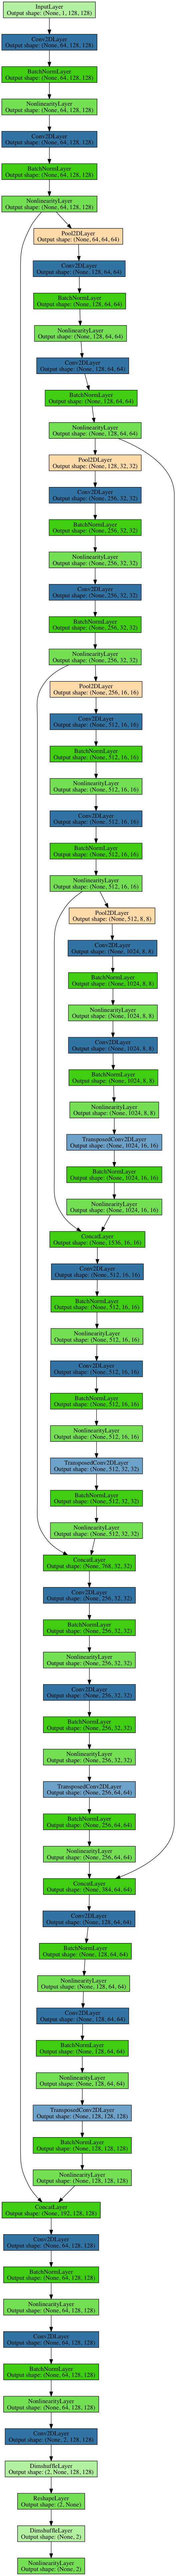

In [5]:
draw_to_notebook(lasagne.layers.get_all_layers([network]))